In [52]:
import sys, os



%load_ext autoreload
%autoreload 2

import sys
sys.path.append("..")

import os
os.environ['R_HOME'] = 'D:/Program Files/R-4.5.0' #@TODO include in some setup file

from simulation_engine.scenarios.iv.binary_iv import BinaryIV
from simulation_engine.scenarios.iv.continuous_iv import ContinuousIV
from simulation_engine.scenarios.scenario import Scenario
from simulation_engine.scenarios.conf.binary_conf import BinaryConf
from simulation_engine.util.plotting_util import PlottingUtil
from simulation_engine.algorithms.causaloptim import Causaloptim
from simulation_engine.algorithms.zhang_bareinboim import ZhangBareinboim
from simulation_engine.algorithms.apid import Apid
from simulation_engine.algorithms.apid_src.src.models.apid import APID

import pandas as pd
pd.set_option('display.max_columns', None)

#disable warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from simulation_engine.algorithms.zaffalonbounds import ZaffalonBounds
from hydra import compose, initialize
from omegaconf import OmegaConf

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [50]:
data = BinaryIV.generate_data_rolling_ate(2)
binaryIV = BinaryIV('IV Dag', data)
algs = ['PNS_tianpearl', 'ATE_tianpearl', 'ATE_manski']

algorithms = [alg for alg in binaryIV.get_algorithms('ATE') if 'zaffalonbounds' not in alg]
algorithms
runtimes = binaryIV.run()
# binaryIV.data['entropy_U'].describe()

Running ATE_2SLS-0.99...
ATE_2SLS-0.99 completed in 0.08 seconds.
Running ATE_2SLS-0.98...
ATE_2SLS-0.98 completed in 0.02 seconds.
Running ATE_2SLS-0.95...
ATE_2SLS-0.95 completed in 0.04 seconds.
Running ATE_causaloptim...
ATE_causaloptim completed in 2.57 seconds.
Running PNS_causaloptim...
PNS_causaloptim completed in 1.85 seconds.
Running ATE_autobound...
ATE_autobound completed in 0.86 seconds.
Running PNS_autobound...
PNS_autobound completed in 0.69 seconds.
Running ATE_entropybounds-0.80...
ATE_entropybounds-0.80 completed in 0.20 seconds.
Running ATE_entropybounds-0.20...
ATE_entropybounds-0.20 completed in 0.13 seconds.
Running ATE_entropybounds-0.10...
ATE_entropybounds-0.10 completed in 0.15 seconds.
Running PNS_entropybounds-0.80...
PNS_entropybounds-0.80 completed in 0.05 seconds.
Running PNS_entropybounds-0.20...
PNS_entropybounds-0.20 completed in 0.07 seconds.
Running PNS_entropybounds-0.10...
PNS_entropybounds-0.10 completed in 0.07 seconds.
Running PNS_entropybounds-

d:\TUM Workspace\Thesis Workspace\causal-bounds\simulation_engine\..\simulation_engine\algorithms\zaffalonbounds.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[results_df.columns] = results_df
d:\TUM Workspace\Thesis Workspace\causal-bounds\simulation_engine\..\simulation_engine\algorithms\zaffalonbounds.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[results_df.columns] = results_df
d:\TUM Workspace\Thesis Workspace\causal-bounds\simulation_engine\..\simulation_engine\algorithms\zaffalonbounds.py:30: Perfor

ATE_zaffalonbounds completed in 20.63 seconds.
Running PNS_zaffalonbounds...
PNS_zaffalonbounds completed in 18.32 seconds.
Running ATE_tianpearl...
ATE_tianpearl completed in 0.01 seconds.
Running PNS_tianpearl...
PNS_tianpearl completed in 0.01 seconds.
Running ATE_manski...
ATE_manski completed in 0.01 seconds.
Total runtime: 46.17 seconds.


d:\TUM Workspace\Thesis Workspace\causal-bounds\simulation_engine\..\simulation_engine\algorithms\zaffalonbounds.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[results_df.columns] = results_df
d:\TUM Workspace\Thesis Workspace\causal-bounds\simulation_engine\..\simulation_engine\algorithms\zaffalonbounds.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[results_df.columns] = results_df
d:\TUM Workspace\Thesis Workspace\causal-bounds\simulation_engine\..\simulation_engine\algorithms\zaffalonbounds.py:30: Perfor

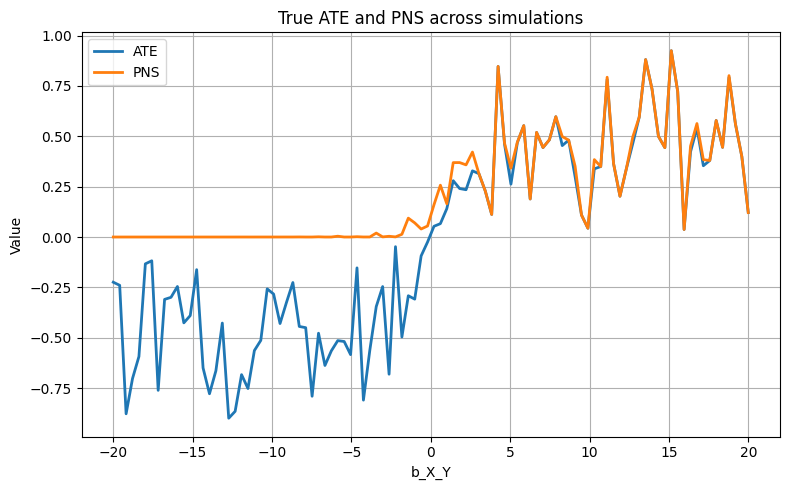

In [ ]:
PlottingUtil.plot_ate_pns(BinaryConf.generate_data_rolling_ate(2000))

                    Algorithm Fail Rate (%) Invalid Rate (%) Net Bound Width Bound Width Invalid Δ (%)
                PNS_tianpearl          0.00            50.00          0.0696      0.0696          0.00
           PNS_zaffalonbounds          0.00             0.00          0.1471      0.1471           N/A
              PNS_causaloptim          0.00             0.00          0.3673      0.3673           N/A
                PNS_autobound          0.00             0.00          0.3936      0.3936           N/A
       PNS_entropybounds-0.10          0.00             0.00          0.4954      0.4954           N/A
       PNS_entropybounds-0.20          0.00             0.00          0.5616      0.5616           N/A
  PNS_entropybounds-trueTheta          0.00             0.00          0.6700      0.6700           N/A
       PNS_entropybounds-0.80          0.00             0.00          0.6700      0.6700           N/A
PNS_entropybounds-randomTheta          0.00             0.00          0.6

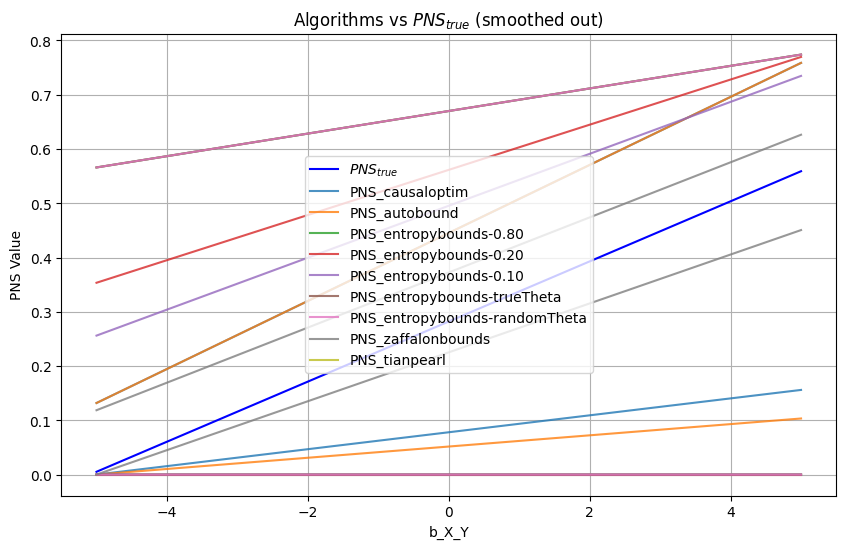

In [49]:
query = 'PNS'
ate_algs = PlottingUtil.extract_algorithm_names(binaryIV.data, query)
# PlottingUtil.print_bound_statistics(binaryIV.data, ate_algs)
PlottingUtil.print_bound_statistics_table(binaryIV.data, ate_algs)
PlottingUtil.plot_smoothed_query_vs_bounds(binaryIV.data, query, ate_algs, 1, False)

# ContinousIV Test

[autoreload of simulation_engine.scenarios.iv.continuous_iv failed: Traceback (most recent call last):
  File "C:\Users\tmari\AppData\Roaming\Python\Python312\site-packages\IPython\extensions\autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "C:\Users\tmari\AppData\Roaming\Python\Python312\site-packages\IPython\extensions\autoreload.py", line 475, in superreload
    module = reload(module)
             ^^^^^^^^^^^^^^
  File "d:\Programme\anaconda\envs\py312\Lib\importlib\__init__.py", line 131, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 866, in _exec
  File "<frozen importlib._bootstrap_external>", line 991, in exec_module
  File "<frozen importlib._bootstrap_external>", line 1129, in get_code
  File "<frozen importlib._bootstrap_external>", line 1059, in source_to_code
  File "<frozen importlib._bootstrap>", line 488, in _call_with_frames_removed
  File "d:\TUM Workspace\Thesis Workspace\causal-bounds\

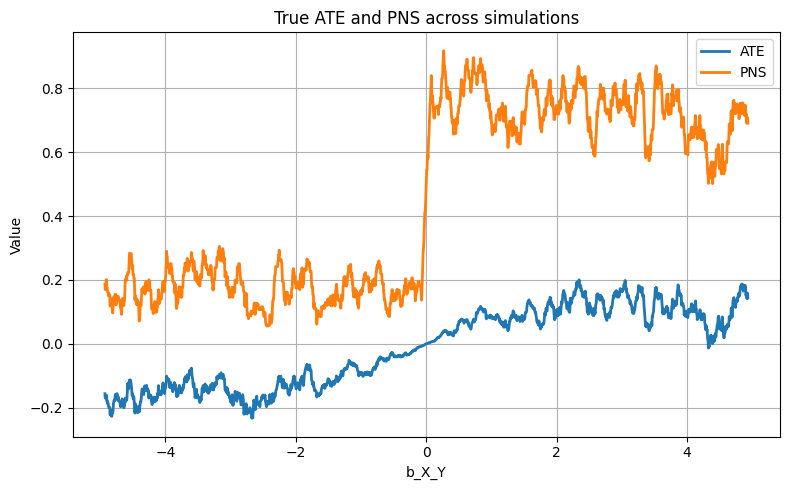

In [34]:
function_keys = [
                "identity",
                "sin",
                "cos",
                "tanh",
                "log1p_abs",
                "exp_neg_sq",
                "sigmoid",
                "exp_clipped"
            ]

data = ContinuousIV.run_rolling_b_X_Y_simulations(
    b_range=(-5, 5), N_points=2000, replications=1, n=500,
)
PlottingUtil.plot_ate_pns(data,window=30)

In [32]:
data = ContinuousIV.run_rolling_b_X_Y_simulations(
        b_range=(-10, 10), N_points=2, replications=1, n=500)

contIV = ContinuousIV('IV DAG', data)
results = contIV.run()
# row_dicts = [row.to_dict() for _, row in data.iterrows()]
# ZaffalonBounds._run_zaffalon_from_row_dict(row_dicts[0], 'ATE')

Running ATE_zhangbareinboim...
ATE_zhangbareinboim completed in 0.45 seconds.
Running ATE_causaloptim--binned...
Entering binned Binary IV Scenario for algorithm: ATE_causaloptim
Running ATE_causaloptim...
ATE_causaloptim completed in 3.63 seconds.
Total runtime: 3.63 seconds.
Exiting binned Binary IV Scenario.
ATE_causaloptim--binned completed in 3.63 seconds.
Running ATE_autobound--binned...
Entering binned Binary IV Scenario for algorithm: ATE_autobound
Running ATE_autobound...
Error in AutoBound: Model constraint (c0) contains nonlinear terms that cannot be written to LP format
ATE_autobound completed in 0.28 seconds.
Total runtime: 0.28 seconds.
Exiting binned Binary IV Scenario.
ATE_autobound--binned completed in 0.28 seconds.
Running ATE_zaffalonbounds--binned...
Entering binned Binary IV Scenario for algorithm: ATE_zaffalonbounds
Running ATE_zaffalonbounds...
ATE_zaffalonbounds completed in 15.27 seconds.
Total runtime: 15.27 seconds.
Exiting binned Binary IV Scenario.
ATE_zaff

In [33]:
contIV.binaryIV.data

,seed,b_Z_X,b_U_X,b_X_Y,b_U_Y,p_Z,sigma_X,sigma_Y,sigma_U,g_U_X,g_U_Y,squash_X,squash_Y,g_Y,ATE_true,PNS_true,p_Y1_mean,p_Y0_mean,Z,U,X,Y,Y_max,Y_min,X_max,X_min,X_mean,Y_mean,entropy_Z,entropy_X,ATE_causaloptim_bound_lower,ATE_causaloptim_bound_upper,ATE_causaloptim_bound_valid,ATE_causaloptim_bound_width,ATE_causaloptim_bound_failed,ATE_autobound_bound_lower,ATE_autobound_bound_upper,ATE_autobound_bound_valid,ATE_autobound_bound_width,ATE_autobound_bound_failed,ATE_zaffalonbounds_bound_lower,ATE_zaffalonbounds_bound_upper,ATE_zaffalonbounds_bound_valid,ATE_zaffalonbounds_bound_width,ATE_zaffalonbounds_bound_failed,ATE_entropybounds-0.80_bound_lower,ATE_entropybounds-0.80_bound_upper,ATE_entropybounds-0.80_bound_valid,ATE_entropybounds-0.80_bound_width,ATE_entropybounds-0.80_bound_failed,ATE_entropybounds-0.20_bound_lower,ATE_entropybounds-0.20_bound_upper,ATE_entropybounds-0.20_bound_valid,ATE_entropybounds-0.20_bound_width,ATE_entropybounds-0.20_bound_failed,ATE_entropybounds-0.10_bound_lower,ATE_entropybounds-0.10_bound_upper,ATE_entropybounds-0.10_bound_valid,ATE_entropybounds-0.10_bound_width,ATE_entropybounds-0.10_bound_failed
0,278722,0.537032,-0.829288,-10.0,0.592425,0.558601,0.542571,0.037940,1.082761,sigmoid_shifted,zero_centered_tanh,tanh_scaled,probit,zero_centered_tanh,-0.332640,0.0,0.158655,0.491296,"[1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, ...","[-0.7732143555552399, -1.9339077684732389, -0....","[0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, ...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...",0.713314,0.158655,1,0,0.446,0.352749,0.992774,0.991570,-0.675556,0.044040,True,0.719596,False,-0.675556,0.135758,True,0.811313,False,-0.5585,-0.0565,True,0.5020,False,-0.722996,0.239163,True,0.962159,False,-0.701127,-0.098180,True,0.602946,False,-0.654482,-0.237055,True,0.417427,False
1,624717,-0.469777,-0.407425,10.0,-1.015155,0.242999,1.520538,0.839096,0.015680,sigmoid_shifted,log1p_abs,probit,sigmoid,log1p_abs,0.304338,1.0,0.915802,0.611463,"[1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, ...","[-0.024654289719913212, -0.030400917327729184,...","[0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.930333,0.500087,1,0,0.408,0.735544,0.791699,0.975438,-0.502547,0.280686,False,0.783233,False,-1.000000,1.000000,True,2.000000,True,-0.4647,0.0030,False,0.4677,False,-0.261338,0.703996,True,0.965334,False,0.090647,0.686207,True,0.595560,False,0.235557,0.643087,True,0.407530,False


                     Algorithm Fail Rate (%) Invalid Rate (%) Net Bound Width Bound Width
                 ATE_2SLS-0.95          0.00             0.00          0.2750      0.2750
                 ATE_2SLS-0.98          0.00             0.00          0.3264      0.3264
                 ATE_2SLS-0.99          0.00             0.00          0.3614      0.3614
ATE_entropybounds-0.10--binned          0.00             0.00          0.4125      0.4125
    ATE_zaffalonbounds--binned          0.00            50.00          0.5020      1.2510
ATE_entropybounds-0.20--binned          0.00             0.00          0.5993      0.5993
       ATE_causaloptim--binned          0.00            50.00          0.7196      1.3598
         ATE_autobound--binned         50.00             0.00          0.8113      1.4057
           ATE_zhangbareinboim          0.00             0.00          0.8695      0.8695
ATE_entropybounds-0.80--binned          0.00             0.00          0.9637      0.9637


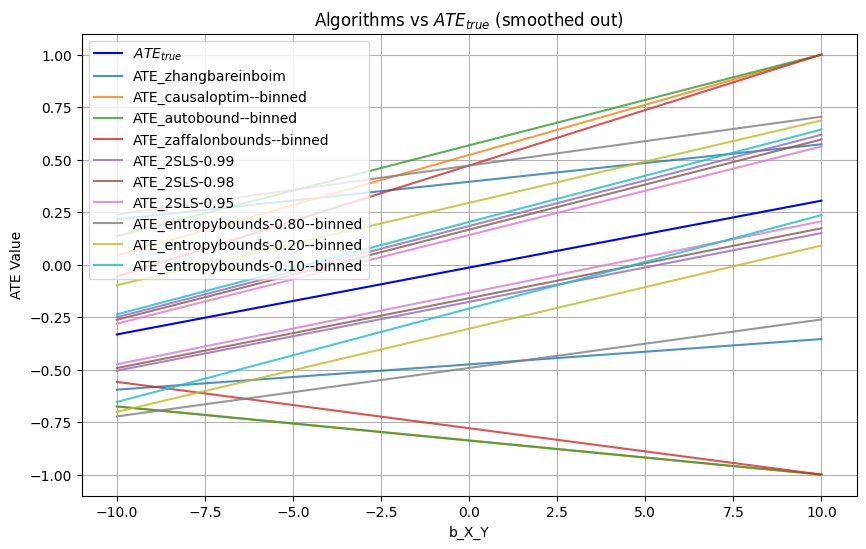

In [34]:
algs = contIV.get_algorithms('ATE')
PlottingUtil.print_bound_statistics_table(contIV.data, algs)
PlottingUtil.plot_smoothed_query_vs_bounds(contIV.data, 'ATE', algs)

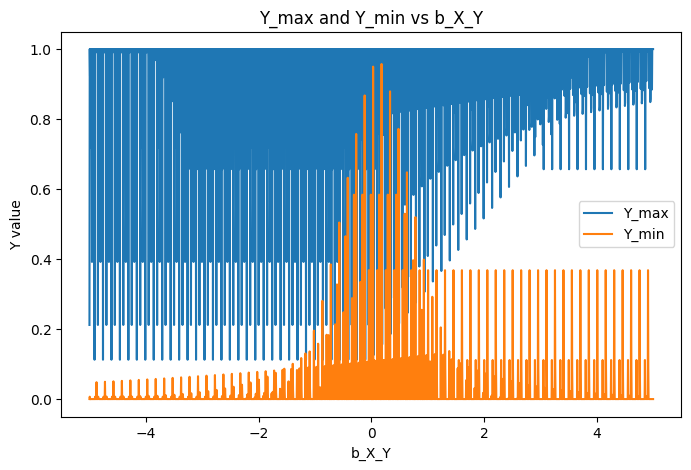

In [107]:
import matplotlib.pyplot as plt

y_label = 'Y'
plt.figure(figsize=(8, 5))
plt.plot(data['b_X_Y'], data[f'{y_label}_max'], label=f'{y_label}_max')
plt.plot(data['b_X_Y'], data[f'{y_label}_min'], label=f'{y_label}_min')
# plt.plot(data['b_X_Y'], data[f'{y_label}_mean'], 'o-', label=f'{y_label}_mean')
plt.xlabel('b_X_Y')
plt.ylabel(f'{y_label} value')
plt.title(f'{y_label}_max and {y_label}_min vs b_X_Y')
plt.legend()
plt.show()

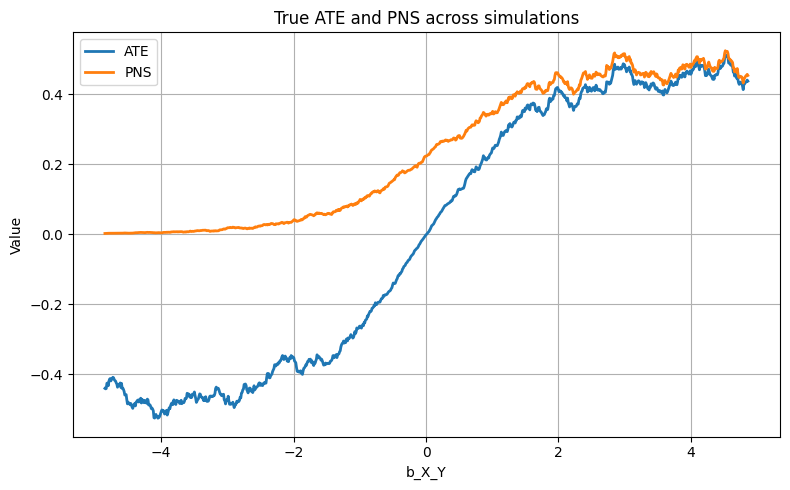

In [49]:
data = BinaryIV.generate_data_rolling_ate(1000, b_lower=-5, b_upper=5)

PlottingUtil.plot_ate_pns(data, window=30)